In [4]:
import xarray
import os
import numpy as np
from GridcellDataset import GridcellDataset
from pathos.multiprocessing import Pool
from random import sample
from datetime import datetime
import iris
import scipy as sp
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neural_network import MLPRegressor
import sklearn

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def _reduce_dim(cube, dim, scale_factor):
    new_dim = np.linspace(cube.coord(dim).points[0], 
                          cube.coord(dim).points[-1],
                          num = cube.coord(dim).points.shape[0] // scale_factor)
    return new_dim

def upscale(cube, scale_factor):
    new = cube.copy()
    new_lat = _reduce_dim(cube, 'grid_latitude', scale_factor)
    new_lon = _reduce_dim(cube, 'grid_longitude', scale_factor)
    return new.interpolate(sample_points=[('grid_latitude', new_lat), ('grid_longitude', new_lon)],
                           scheme=iris.analysis.Linear())

def bilinear_downscale(upscaled, target):
    return upscaled.regrid(target, iris.analysis.Linear()) # defaults to n-linear

In [6]:
def bilinear_downscale_xr(darray, scale_factor):
    time = iris.coords.DimCoord(darray.forecast_reference_time.astype(int),
                                standard_name='time')
    latitude = iris.coords.DimCoord(darray.grid_latitude,
                                    standard_name='grid_latitude')
    longitude = iris.coords.DimCoord(darray.grid_longitude,
                                     standard_name='grid_longitude')

    cube = iris.cube.Cube(darray,
                          dim_coords_and_dims=[(time, 0), (latitude, 1), (longitude, 2)])
    new = darray.copy()
    new.data = bilinear_downscale(upscale(cube, scale_factor), cube).data
    
    return new

In [7]:
def get_set(paths, scale_factor, n):
    sets = [xarray.open_dataset(tp)['stratiform_rainfall_amount'].isel(dim0=2) for tp in paths]
    hr = xarray.concat([ts.drop('forecast_period_3') for ts in sets if 'forecast_period_3' in ts.coords],
              dim='forecast_reference_time')
    hr = hr.reindex(forecast_reference_time=sorted(hr.forecast_reference_time.data))
    lr = bilinear_downscale_xr(hr, scale_factor)
    
    template = lr[:, n:-n, n:-n]
    d = xarray.Dataset({'stratiform_rainfall_amount': lr[:, n:-n, n:-n]})
    d['stratiform_rainfall_amount_left'] = (template.dims, lr[:, :-2*n, n:-n].data)
    d['stratiform_rainfall_amount_right'] = (template.dims, lr[:, 2*n:, n:-n].data)
    d['stratiform_rainfall_amount_up'] = (template.dims, lr[:, n:-n, :-2*n].data)
    d['stratiform_rainfall_amount_down'] = (template.dims, lr[:, n:-n, 2*n:].data)
    d['target'] = hr[:, n:-n, n:-n]
    
    return d

In [8]:
def get_set(paths, scale_factor, ns):
    sets = [xarray.open_dataset(tp)['stratiform_rainfall_amount'].isel(dim0=2) for tp in paths]
    hr = xarray.concat([ts.drop('forecast_period_3') for ts in sets if 'forecast_period_3' in ts.coords],
              dim='forecast_reference_time')
    hr = hr.reindex(forecast_reference_time=sorted(hr.forecast_reference_time.data))
    lr = bilinear_downscale_xr(hr, scale_factor)
    
    m = max(ns)
    template = lr[:, m:-m, m:-m]
    d = xarray.Dataset({'stratiform_rainfall_amount': lr[:, m:-m, m:-m]})
    d['target'] = hr[:, m:-m, m:-m]
    for n in ns:
        d['stratiform_rainfall_amount_left_{:d}'.format(n)] = \
        (template.dims, lr[:, :-2*n, n:-n][:, :-(2*m-2*n) or None, (m-n):-(m-n) or None].data)
        d['stratiform_rainfall_amount_right_{:d}'.format(n)] = \
        (template.dims, lr[:, 2*n:, n:-n][:, 2*m-2*n:, (m-n):-(m-n) or None].data)
        d['stratiform_rainfall_amount_down_{:d}'.format(n)] = \
        (template.dims, lr[:, n:-n, :-2*n][:, m-n:-(m-n) or None, :-(2*m-2*n) or None].data)
        d['stratiform_rainfall_amount_up_{:d}'.format(n)] = \
        (template.dims, lr[:, n:-n, 2*n:][:, m-n:-(m-n) or None, (2*m-2*n):].data)
        d['stratiform_rainfall_amount_down_left_{:d}'.format(n)] = \
        (template.dims, lr[:, :-2*n, :-2*n][:, :-(2*m-2*n) or None, :-(2*m-2*n) or None].data)
        d['stratiform_rainfall_amount_down_right_{:d}'.format(n)] = \
        (template.dims, lr[:, 2*n:, :-2*n][:, 2*m-2*n:, :-(2*m-2*n) or None].data)
        d['stratiform_rainfall_amount_up_left_{:d}'.format(n)] = \
        (template.dims, lr[:, :-2*n, 2*n:][:, :-(2*m-2*n) or None, (2*m-2*n):].data)
        d['stratiform_rainfall_amount_up_right_{:d}'.format(n)] = \
        (template.dims, lr[:, 2*n:, 2*n:][:, 2*m-2*n:, (2*m-2*n):].data)
    
    return d

In [9]:
path = '../netcdf/'
paths = [f for f in os.listdir(path) if f[:5] == 'prods']
train_paths = [p for p in paths if int(p[26:28]) < 10]
test_paths = [p for p in paths if int(p[26:28]) > 10]

In [10]:
train = get_set([path + tp for tp in train_paths], 8, [1,2,3,4,5])
test = get_set([path + tp for tp in test_paths], 8, [1,2,3,4,5])

In [11]:
# train_lr.grid_latitude[np.where(train_lr[0] == 0)[0]]

In [12]:
# nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(ospts)

In [13]:
train_vars = [v for v in train.data_vars if v != 'target']

training_data = train.to_dataframe()[train_vars + ['target']]

In [14]:
model = RandomForestRegressor()
sample = training_data.sample(100000)
model.fit(sample[train_vars], sample['target'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

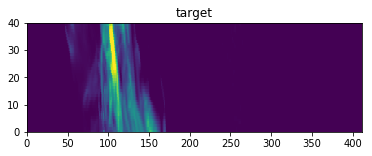

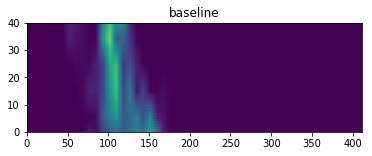

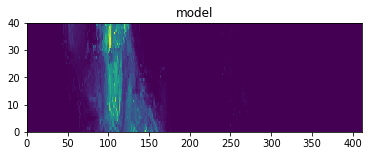

In [15]:
i = 4
m = 6

plt.figure(figsize=(6,2))
plt.pcolormesh(test.isel(forecast_reference_time=i)['target'], vmax=m)
plt.title('target')
plt.show()

plt.figure(figsize=(6,2))
plt.pcolormesh(test.isel(forecast_reference_time=i)['stratiform_rainfall_amount'], vmax=m)
plt.title('baseline')
plt.show()

plt.figure(figsize=(6,2))
plt.pcolormesh(model.predict(test.isel(forecast_reference_time=i)[train_vars]\
                             .to_array().data.T.reshape(-1, len(train_vars))).reshape(test.dims['grid_longitude'], 
                                                                                      test.dims['grid_latitude']).T,
               vmax=m)
plt.title('model')
plt.show()

In [32]:
for i in range(12):
    print(
        np.sum(np.abs(np.gradient(test.isel(forecast_reference_time=i)['stratiform_rainfall_amount'])[0])) /\
        np.sum(np.abs(test.isel(forecast_reference_time=i)['stratiform_rainfall_amount'].data))
    )

nan
0.112250053468
0.190866886334
nan
0.0469928613909
0.0771824725829
0.142250566371
0.10550438816
0.165703350445
0.112291763731
0.0411833446745
0.0986440777315


 /home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning:invalid value encountered in double_scalars


In [33]:
for i in range(12):
    print(
        np.sum(np.abs(np.gradient(test.isel(forecast_reference_time=i)['target'])[0])) /\
        np.sum(np.abs(test.isel(forecast_reference_time=i)['target'].data))
    )

1.25
0.455613821519
0.668014557218
nan
0.0975388909852
0.164837177642
0.360924843088
0.232769515076
0.332179530444
0.232190732409
0.0779947288839
0.23070050548


 /home/ubuntu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning:invalid value encountered in double_scalars


In [34]:
for i in range(12):
    preds = model.predict(test.isel(forecast_reference_time=i)[train_vars]\
                             .to_array().data.T.reshape(-1, len(train_vars))).reshape(test.dims['grid_longitude'], 
                                                                                      test.dims['grid_latitude']).T
    
    print(
        np.sum(np.abs(np.gradient(preds)[0])) /\
        np.sum(np.abs(preds.data))
    )

0.0
0.342347538801
0.518404966917
0.0
0.144567653013
0.21975101927
0.416774602116
0.277110763423
0.418955938281
0.357328248826
0.152394964469
0.263968082898


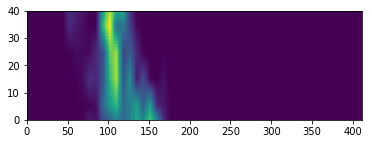

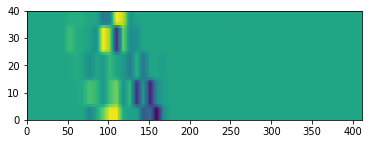

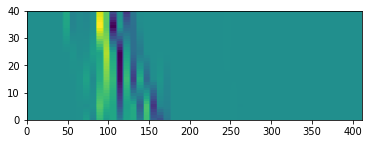

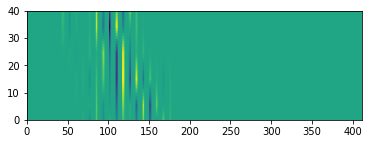

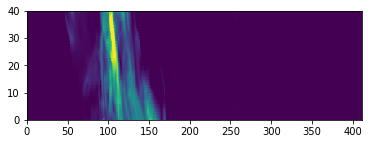

In [16]:
plt.figure(figsize=(6,2))
plt.pcolormesh(test.isel(forecast_reference_time=i)['stratiform_rainfall_amount'])
plt.show()
plt.figure(figsize=(6,2))
plt.pcolormesh(np.gradient(test.isel(forecast_reference_time=i)['stratiform_rainfall_amount'])[0])
plt.show()
plt.figure(figsize=(6,2))
plt.pcolormesh(np.gradient(test.isel(forecast_reference_time=i)['stratiform_rainfall_amount'])[1])
plt.show()
plt.figure(figsize=(6,2))
plt.pcolormesh(np.gradient(np.gradient(test.isel(forecast_reference_time=i)['stratiform_rainfall_amount'])[1])[1])
plt.show()
plt.figure(figsize=(6,2))
plt.pcolormesh(test.isel(forecast_reference_time=i)['target'], vmax=m);

In [2]:
import GPy

In [3]:
sample = training_data.sample(1000)

k = GPy.kern.RBF(input_dim=9, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(sample[train_vars], sample[['target']], k, noise_var=0.1)
m.optimize()
m = GPy.models.GPRegression(sample[train_vars], sample[['stratiform_rainfall_amount']], k, noise_var=5)

NameError: name 'training_data' is not defined

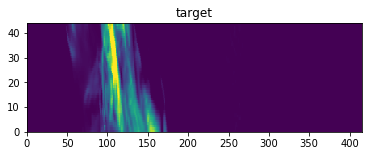

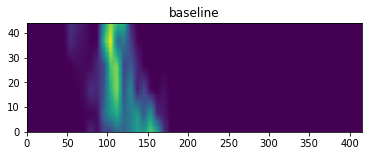

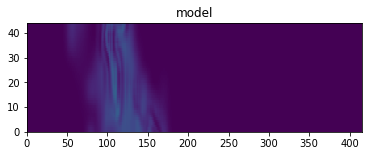

In [25]:
i = 4
vmax = 5

plt.figure(figsize=(6,2))
plt.pcolormesh(test.isel(forecast_reference_time=i)['target'], vmax=vmax)
plt.title('target')
plt.show()

plt.figure(figsize=(6,2))
plt.pcolormesh(test.isel(forecast_reference_time=i)['stratiform_rainfall_amount'], vmax=vmax)
plt.title('baseline')
plt.show()

plt.figure(figsize=(6,2))
plt.pcolormesh(m.predict(test.isel(forecast_reference_time=i)[train_vars]\
                             .to_array().data.T.reshape(-1, len(train_vars)))[0].reshape(test.dims['grid_longitude'], 
                                                                                      test.dims['grid_latitude']).T,
               vmax=vmax)
plt.title('model')
plt.show()

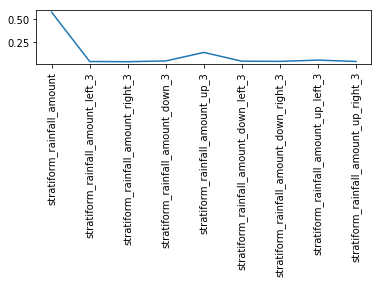

In [13]:
plt.figure(figsize=(6,1))
plt.plot(range(len(train_vars)), model.feature_importances_)
plt.gca().set_xticks(range(len(train_vars)))
plt.gca().set_xticklabels(train_vars, rotation='vertical');

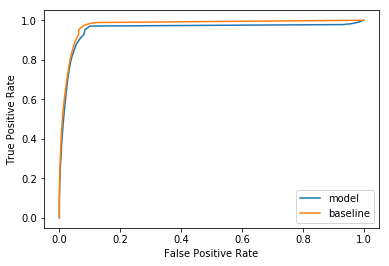

In [14]:
yhat = model.predict(test[train_vars].to_array().data.reshape(len(train_vars), -1).T).flatten()
true = (test['target'] > 0).astype(int).values.flatten()
fpr, tpr, _ = sklearn.metrics.roc_curve(true, yhat)
plt.plot(fpr, tpr, label='model')
plt.gca().set_xlabel('False Positive Rate')
plt.gca().set_ylabel('True Positive Rate')

yhat = test['stratiform_rainfall_amount'].data.flatten()
true = (test['target'] > 0).astype(int).values.flatten()
fpr, tpr, _ = sklearn.metrics.roc_curve(true, yhat)
plt.plot(fpr, tpr, label='baseline')
plt.gca().set_xlabel('False Positive Rate')
plt.gca().set_ylabel('True Positive Rate')

plt.legend();

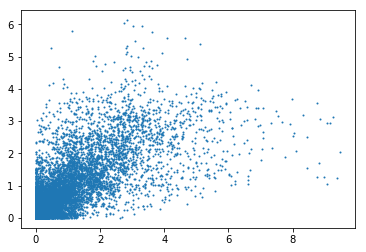

In [15]:
plt.scatter(test['target'].values.flatten(), 
            model.predict(test[train_vars].to_array().data.reshape(len(train_vars), -1).T).flatten(),
            s=1)

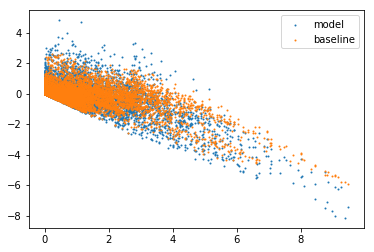

In [16]:
plt.scatter(test['target'].values.flatten(), 
            (model.predict(test[train_vars].to_array().data.reshape(len(train_vars), -1).T).flatten()\
                  - test['target'].values.flatten()),
            s=1,
            label='model')
plt.scatter(test['target'].values.flatten(), 
            test['stratiform_rainfall_amount'].values.flatten() - test['target'].values.flatten(),
            s=1,
            label='baseline')
plt.legend()

In [17]:
print('model mse')
np.mean(np.square(model.predict(test[train_vars].to_array().data.reshape(len(train_vars), -1).T).flatten() - \
                  test['target'].values.flatten()))

model mse


0.037155112630995767

In [18]:
print('baseline mse')
np.mean(np.square(test['stratiform_rainfall_amount'].data.flatten() - \
                  test['target'].values.flatten()))

baseline mse


0.021914918879242015

In [916]:
for s in [2,4,8]:
    model_scores = []
    baseline_scores = []
    for n in range(1,12):
        train_n = get_set([path + tp for tp in train_paths], 8, n)
        test_n = get_set([path + tp for tp in test_paths], 8, n)
        training_data_n = train_n.to_dataframe()[train_vars + ['target']]

        model_n = RandomForestRegressor(n_estimators=30)
        sample = training_data_n.sample(1000)
        model_n.fit(sample[train_vars], sample['target'])

        model_scores.append(np.mean(np.square(model_n.predict(test_n[train_vars].to_array()\
                                                            .data.reshape(len(train_vars), -1).T).flatten() - \
                              test_n['target'].values.flatten())))
        baseline_scores.append(np.mean(np.square(test_n['stratiform_rainfall_amount'].data.flatten() - \
                              test_n['target'].values.flatten())))

    plt.plot(range(1,12), model_scores, label='model {:d}'.format(s))
plt.plot(range(1,12), baseline_scores, label='baseline')
plt.legend()

TypeError: 'int' object is not iterable

linear model - fit orography first
aov
train on only rainy cells
try wind data

bayesian bootstrap

gauss markov random field
Chris wickle - dynamics in ml
Sebastian Reich - data assimilation

who cares, why, and what do they need?

Intro: broad interests
Downscaling methods
 - Dynamic
 - Statistical
 - Intemediate
Spatial / coupled stats and machine learning (multioutput)
Ensembles
Evaluation